Comparing the DWI using two sets of data: bias corrected using NRMBC and QME

In [1]:
import dask
from dask.distributed import Client, wait
from dask import delayed

client = Client(n_workers=7, threads_per_worker=1) 
#client = Client()

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41037,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:36797,Total threads: 1
Dashboard: /proxy/42839/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:39017,


In [2]:
#import all the stuff
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append("/g/data/mn51/users/nb6195/project/gwls/")
import gwl

In [28]:
sys.path.append("/g/data/mn51/users/nb6195/project/dwi/DWI")
import DWI_functions

In [5]:
#function to calculate dewpoint depression
#inputs: datasets of temperature and relative humidity
#outputs: a dataset of dewpoint depression
def calc_dpd(ds_temp, ds_rh):
    dpd = ds_temp - 243.5 * (np.log(ds_rh/100) + 17.67*ds_temp/(243.5 + ds_temp))/(17.67 - (np.log(ds_rh/100) + 17.67*ds_temp/(243.5 + ds_temp)))

    dpd.attrs = {
        'long_name': 'afternoon dewpoint depression computed from tasmax and hursmin',
        'standard_name': 'dpd',
        'units': 'degC',
        'program' : 'Australian Climate Service (ACS)',
        'summary' : f'Fire weather metric: dewpoint depression for Global Warming Level {chosen_gwl} C',
        'naming_authority' : "Bureau of Meteorology",
        'publisher_type' : "group",
        'publisher_type' : "group" ,
        'publisher_institution' : "Bureau of Meteorology",
        'publisher_name' : "Bureau of Meteorology",
        'publisher_url' : "http://www.bom.gov.au",
        'creator_type' : "institution" ,
        'creator_institution' : "Bureau of Meteorology" ,
        'contact' : "Naomi Benger (naomi.benger@bom.gov.au)" ,
        'institute_id' : "BOM" ,
        'institution' : "Bureau of Meteorology",
#        'regrid_method': 'bilinear'
    }
    ds_dpd = xr.Dataset({'dpd' : dpd})
    ds_rh.close()
    ds_temp.close()
    
    return ds_dpd

In [6]:
def calc_dwi(ds_temp, ds_rh, ds_wind_sp, A, B, C, D):
    dwi = (calc_dpd(ds_temp, ds_rh)['dpd'] + A)/B * (ds_wind_sp + C)/D

    dwi.attrs = {
    'long_name': 'afternoon dry-windy index computed from tasmax, hursmin, maximum wind speed, and the tuned constants',
    'standard_name': 'dwi',
    'units': 'km h-1',
    'program' : 'Australian Climate Service (ACS)',
    'summary' : f'Fire weather metric: Dry-windy index for Global Warming Level {chosen_gwl} C',
    'naming_authority' : "Bureau of Meteorology",
    'publisher_type' : "group",
    'publisher_type' : "group" ,
    'publisher_institution' : "Bureau of Meteorology",
    'publisher_name' : "Bureau of Meteorology",
    'publisher_url' : "http://www.bom.gov.au",
    'creator_type' : "institution" ,
    'creator_institution' : "Bureau of Meteorology" ,
    'contact' : "Naomi Benger (naomi.benger@bom.gov.au)" ,
    'institute_id' : "BOM" ,
    'institution' : "Bureau of Meteorology",
#    'regrid_method': 'bilinear'
#    'acknowledgement' : "Development of data supported with funding from the Australian Climate Service.",
    }
    ds_dwi = xr.Dataset({'dwi' : dwi})
    ds_rh.close()
    ds_temp.close()
    ds_wind_sp.close()
    return ds_dwi

In [7]:
#conversion factor to FFDI from Kevin
#Psudo FFDI: (50/3)*(DF/10) matching FFDI for a particular event provided by Musa, 30 Sept 2023
#also computed for mean T humidity for Melb airport for Feb for total obs history at that time
#this removes the wind speed bias - FFDI undersensitive to wind and over sensitive to temp, 
#they often compensate. But not great on cool windy days
def calc_p_ffdi(ds_dwi):
    p_ffdi = 50/3*ds_dwi

    p_ffdi.attrs = {
    'long_name': 'Psudo FFDI computed from tasmax, hursmin, maximum wind speed, and the tuned constants',
    'standard_name': 'p_ffdi',
    #'units': 'km h-1',
    'program' : 'Australian Climate Service (ACS)',
    'summary' : f'Fire weather metric: p_ffdi for Global Warming Level {chosen_gwl} C',
    'naming_authority' : "Bureau of Meteorology",
    'publisher_type' : "group",
    'publisher_type' : "group" ,
    'publisher_institution' : "Bureau of Meteorology",
    'publisher_name' : "Bureau of Meteorology",
    'publisher_url' : "http://www.bom.gov.au",
    'creator_type' : "institution" ,
    'creator_institution' : "Bureau of Meteorology" ,
    'contact' : "Naomi Benger (naomi.benger@bom.gov.au)" ,
    'institute_id' : "BOM" ,
    'institution' : "Bureau of Meteorology",
#    'regrid_method': 'bilinear'
#    'acknowledgement' : "Development of data supported with funding from the Australian Climate Service.",
    }
    ds_p_ffdi = xr.Dataset({'p_ffdi' : p_ffdi})
    ds_dwi.close()
    return ds_p_ffdi

In [8]:
#conversion factor to FFDI from Kevin
#Faux FFDI: (T + 12)(DF/10)/2 

def calc_faux_ffdi(ds_dwi, ds_temp):
    faux_ffdi = (ds_temp + 12)*ds_dwi/2

    faux_ffdi.attrs = {
    'long_name': 'Faux FFDI computed from tasmax, hursmin, maximum wind speed, and the tuned constants',
    'standard_name': 'faux_ffdi',
    #'units': 'km h-1',
    'program' : 'Australian Climate Service (ACS)',
    'summary' : f'Fire weather metric: faux_ffdi for Global Warming Level {chosen_gwl} C',
    'naming_authority' : "Bureau of Meteorology",
    'publisher_type' : "group",
    'publisher_type' : "group" ,
    'publisher_institution' : "Bureau of Meteorology",
    'publisher_name' : "Bureau of Meteorology",
    'publisher_url' : "http://www.bom.gov.au",
    'creator_type' : "institution" ,
    'creator_institution' : "Bureau of Meteorology" ,
    'contact' : "Naomi Benger (naomi.benger@bom.gov.au)" ,
    'institute_id' : "BOM" ,
    'institution' : "Bureau of Meteorology",
#    'regrid_method': 'bilinear'
#    'acknowledgement' : "Development of data supported with funding from the Australian Climate Service.",
    }
    ds_faux_ffdi = xr.Dataset({'faux_ffdi' : faux_ffdi})
    ds_temp.close()
    ds_dwi.close()
    return ds_faux_ffdi

In [9]:
#Set parameters
CMIP='CMIP6'
#AGENCY = 'CSIRO' 
#RCM = 'CCAM-v2203-SN'
AGENCY = 'BOM' 
RCM = 'BARPA-R'

GCM = 'ACCESS-CM2' 
ensemble = 'r4i1p1f1' #Done
#GCM = 'ACCESS-ESM1-5' ensemble = 'r6i1p1f1' #Done
#GCM = 'EC-Earth3' ensemble = 'r1i1p1f1' #Done
#GCM = 'MPI-ESM1-2-HR' ensemble = 'r1i1p1f1' #BOM done, no CSIRO
#GCM = 'CESM2' ensemble = 'r11i1p1f1' #Done
#GCM = 'CMCC-ESM2' ensemble = 'r1i1p1f1' #Done
#GCM = 'NorESM2-MM' ensemble = 'r1i1p1f1' #Done
#GCM = 'CNRM-ESM2-1' ensemble = 'r1i1p1f2' #CSIRO Done, no BOM

#pathway = 'ssp126'
pathway = 'ssp370'

ddir = f"/g/data/kj66/CORDEX/output/{CMIP}/bias-adjusted-output/AUST-05i/{AGENCY}/{GCM}"
output_dir = '/g/data/ia39/ncra/bushfire/dwi/'
#output_dir_mm = '/g/data/ia39/ncra/bushfire/dwi/monthly_mean/'

In [10]:
var1 = 'tasmaxAdjust'
var2 = 'hursminAdjust'
var3 = 'sfcWindmaxAdjust'

In [11]:
#read in MRNBC files

#tasmax
infiles1a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var1}/v20241216/{var1}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
infiles1b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var1}/v20241216/{var1}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
MRNBC_tasmax_master_ds = xr.open_mfdataset(infiles1a + infiles1b)

#hursmin
infiles2a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
infiles2b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
MRNBC_hursmin_master_ds = xr.open_mfdataset(infiles2a + infiles2b)

#wind
infiles3a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
infiles3b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
MRNBC_wind_sp_master_ds = xr.open_mfdataset(infiles3a + infiles3b)

In [12]:
#read in QME files

#tasmax
infiles1a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var1}/v20241216/{var1}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
infiles1b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var1}/v20241216/{var1}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
QME_tasmax_master_ds = xr.open_mfdataset(infiles1a + infiles1b)

#hursmin
infiles2a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
infiles2b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
QME_hursmin_master_ds = xr.open_mfdataset(infiles2a + infiles2b)

#wind
infiles3a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
infiles3b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
QME_wind_sp_master_ds = xr.open_mfdataset(infiles3a + infiles3b)

In [14]:
#Extract time period corresponding to the chosen GWL for tasmax and rh
chosen_gwl = '3.0'

MRNBC_gwl_tasmax = gwl.get_GWL_timeslice(MRNBC_tasmax_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var1]
MRNBC_gwl_rh = gwl.get_GWL_timeslice(MRNBC_hursmin_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var2]
MRNBC_gwl_wind_sp = gwl.get_GWL_timeslice(MRNBC_wind_sp_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var3]

QME_gwl_tasmax = gwl.get_GWL_timeslice(QME_tasmax_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var1]
QME_gwl_rh = gwl.get_GWL_timeslice(QME_hursmin_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var2]
QME_gwl_wind_sp = gwl.get_GWL_timeslice(QME_wind_sp_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var3]

In [13]:
#Vesta DWI: fire spread rate, expect up to 10% of wind speed in 
#extreme conditions (very dry M. Cruz results).
#Values here from the paper provide an excellent approximation for 
#windspeeds between 10 and 80 km\ h^{-1}, using the longest unburned 
#fuel settings (10+ years) provided in Table 6 of Cheney et al. (2012).  
A = 5
B = 20
C = 0
D = 25

Create the DWI data for each bc

In [15]:
#calculate the DWI for each data set
MRNBC_gwl_dwi = calc_dwi(MRNBC_gwl_tasmax, MRNBC_gwl_rh, MRNBC_gwl_wind_sp, A, B, C, D)['dwi']
QME_gwl_dwi = calc_dwi(QME_gwl_tasmax, QME_gwl_rh, QME_gwl_wind_sp, A, B, C, D)['dwi']

Plot them for one day and their differences, see if it looks OK

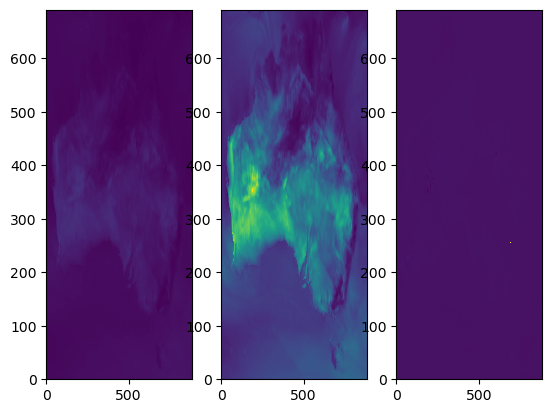

In [16]:
fh, axes = plt.subplots(ncols = 3)
axes[0].pcolormesh(MRNBC_gwl_dwi[5])
axes[1].pcolormesh(QME_gwl_dwi[5])
ph=axes[2].pcolormesh(MRNBC_gwl_dwi[5] - QME_gwl_dwi[5])
#plt.colorbar(ph)

Now create monthly means

In [17]:
monthly_mean_MRNBC_gwl_dwi = MRNBC_gwl_dwi.groupby('time.month').mean('time', keep_attrs=True)
monthly_mean_QME_gwl_dwi = QME_gwl_dwi.groupby('time.month').mean('time', keep_attrs=True)

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in log
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


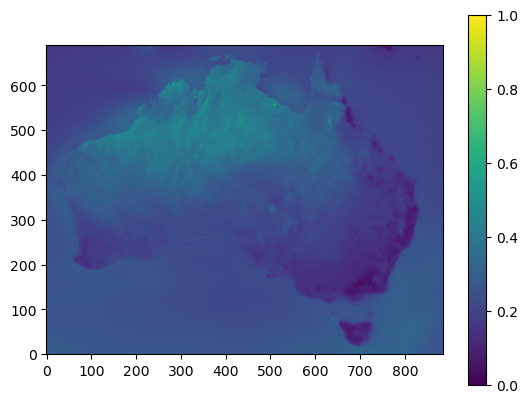

In [18]:
plt.imshow(monthly_mean_MRNBC_gwl_dwi[5], vmin = 0, vmax = 1, origin='lower')
plt.colorbar()

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in log
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in log
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in log
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in log
  return self.func(*new_argspec)


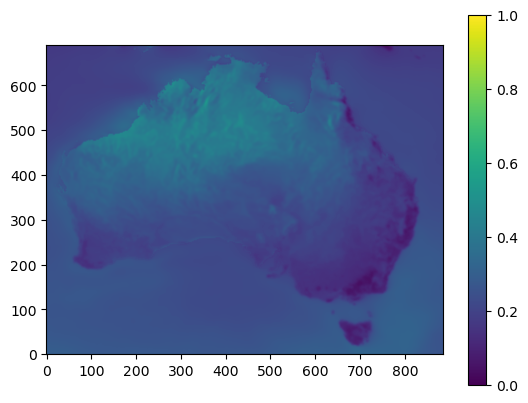

In [19]:
plt.imshow(monthly_mean_QME_gwl_dwi[5], vmin = 0, vmax = 1, origin='lower')
plt.colorbar()

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in log
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in log
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in log
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/en

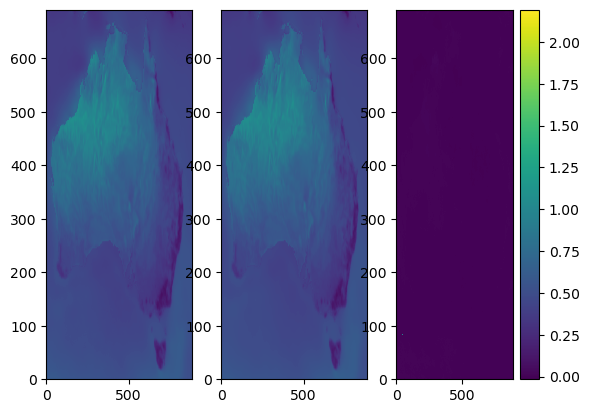

In [20]:
fh, axes = plt.subplots(ncols = 3)
axes[0].pcolormesh(monthly_mean_MRNBC_gwl_dwi[4], vmin = 0, vmax = 1)
axes[1].pcolormesh(monthly_mean_QME_gwl_dwi[4], vmin = 0, vmax = 1)
ph=axes[2].pcolormesh(monthly_mean_MRNBC_gwl_dwi[4] - monthly_mean_QME_gwl_dwi[4])
plt.colorbar(ph)

In [22]:
diff = monthly_mean_MRNBC_gwl_dwi[4] - monthly_mean_QME_gwl_dwi[4]

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in log
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in log
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in log
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


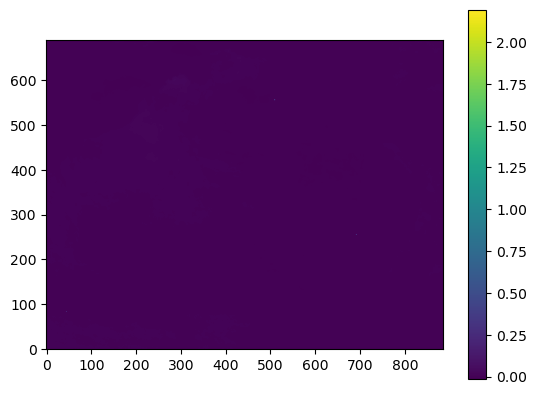

In [23]:
plt.imshow(diff, origin='lower')
plt.colorbar()

In [21]:
perc_QME_gwl_dwi = QME_gwl_dwi.chunk({'time' : -1, 'lat' : 50, 'lon' : 50}).groupby('time.month').quantile(0.9)

In [22]:
perc_MRNBC_gwl_dwi = MRNBC_gwl_dwi.chunk({'time' : -1, 'lat' : 50, 'lon' : 50}).groupby('time.month').quantile(0.9)

In [85]:
#perc_MRNBC_gwl_dwi = np.percentile(MRNBC_gwl_dwi.groupby('time.month'), 90, axis='time')

In [ ]:
fh, axes = plt.subplots(ncols = 3)
axes[0].pcolormesh(perc_MRNBC_gwl_dwi[4], vmin = 0, vmax = 1)
axes[1].pcolormesh(perc_QME_gwl_dwi[4], vmin = 0, vmax = 1)
ph=axes[2].pcolormesh(perc_MRNBC_gwl_dwi[4] - perc_QME_gwl_dwi[4])
plt.colorbar(ph)

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in log
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in log
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/dask/_task_spec.py:651: RuntimeWarning: divide by zero encountered in log
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/e